### Methodology
#### The expected content of the notebook:
    - Detection of time series changes in facial action units

#### Data - data frame of facial action units of James (using OpenFace for windows)

In [1]:
import sys
import os
import warnings

import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
# import CRD_functions as crd

from jmspack.NLTSA import (ts_levels, 
                           distribution_uniformity, 
                           fluctuation_intensity, 
                           complexity_resonance, 
                           complexity_resonance_diagram,
                          cumulative_complexity_peaks,
                          cumulative_complexity_peaks_plot)

from sinfo import sinfo

#### Display the session info of the notebook

In [2]:
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
jmspack     0.0.3
matplotlib  3.3.4
numpy       1.19.2
pandas      1.2.3
seaborn     0.11.1
sinfo       0.3.4
sklearn     0.24.2
-----
IPython             7.21.0
jupyter_client      6.1.7
jupyter_core        4.7.1
jupyterlab          3.0.11
notebook            6.3.0
-----
Python 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Windows-10-10.0.19041-SP0
16 logical CPU cores, AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD
-----
Session information updated at 2021-07-11 22:59


In [3]:
# ========================
# PERSONAL PREFERENCES
# Set pandas output preferences
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
# Set seaborn plot style
plt.style.use('seaborn')
# ========================

In [4]:
# read in data and sort data frame based on frame
jms_facs = pd.read_csv("data/FACs_Test2.csv").sort_values(by=['frame'])

In [5]:
eye_cols = jms_facs.filter(regex="eye").columns.tolist()
au_cols = jms_facs.filter(regex="AU").columns.tolist()

In [6]:
# select only the action units from the df
# jms_au = jms_facs[eye_cols + au_cols]
jms_au = jms_facs[au_cols]

In [7]:
jms_au = jms_au[800:1400]
jms_au.head()

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
800,1.56,0.0,2.68,2.05,0.0,0.0,0.0,0.0,0.0,0.88,0.0,2.02,1.20,0.0,0.86,0.06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
801,1.82,0.0,2.79,2.02,0.0,0.0,0.0,0.0,0.0,0.92,0.0,2.12,1.06,0.0,0.70,0.11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
802,1.95,0.0,2.91,1.95,0.0,0.0,0.0,0.0,0.0,1.07,0.0,2.06,0.99,0.0,0.55,0.23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
803,1.97,0.0,2.93,2.04,0.0,0.0,0.0,0.0,0.0,1.13,0.0,1.96,1.06,0.0,0.50,0.33,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
804,1.96,0.0,3.02,2.19,0.0,0.0,0.0,0.0,0.0,1.12,0.0,1.99,1.02,0.0,0.50,0.31,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
jms_au.shape

(600, 35)

In [9]:
from sklearn.preprocessing import MinMaxScaler
def variance_threshold(df:pd.DataFrame, 
                       threshold: str):
    scaled_df = pd.DataFrame(MinMaxScaler()
             .fit_transform(
                 df.select_dtypes("number")
             ), 
             columns=df.columns)
    summary_df = (scaled_df
     .var()
     .to_frame(name="variance")
     .assign(feature_type=df.dtypes)
     .assign(discard=lambda x: x["variance"] < threshold)
    )
    
    return summary_df

In [10]:
def nunique_threshold(df:pd.DataFrame, 
                       threshold: str):
    scaled_df = pd.DataFrame(MinMaxScaler()
             .fit_transform(
                 df.select_dtypes("number")
             ), 
             columns=df.columns)
    summary_df = (scaled_df
     .apply(lambda x: x.nunique())
     .to_frame(name="nunique")
     .assign(feature_type=df.dtypes)
     .assign(discard=lambda x: x["nunique"] < threshold)
    )
    
    return summary_df

In [11]:
variance_summary = variance_threshold(df = jms_au, 
                   threshold = 0.01)
var_drop_columns=variance_summary[variance_summary["discard"]].index.tolist()

nunique_summary = nunique_threshold(df=jms_au, threshold=3)
nunique_drop_columns=nunique_summary[nunique_summary["discard"]].index.tolist()

In [12]:
drop_columns = list(set(var_drop_columns) | set(nunique_drop_columns))

In [13]:
scaled_ts_df = pd.DataFrame(MinMaxScaler()
             .fit_transform(
                 jms_au.drop(drop_columns, axis=1)
             ), 
             columns=jms_au.drop(drop_columns, axis=1).columns)

In [14]:
scaled_ts_df.shape

(600, 14)

In [15]:
distribution_uniformity_df = pd.DataFrame(distribution_uniformity(scaled_ts_df, 
                                                                  win=7, 
                                                                  xmin=0, 
                                                                  xmax=1, 
                                                                  col_first=1, 
                                                                  col_last=scaled_ts_df.shape[1])
                                         )
distribution_uniformity_df.columns=scaled_ts_df.columns.tolist()

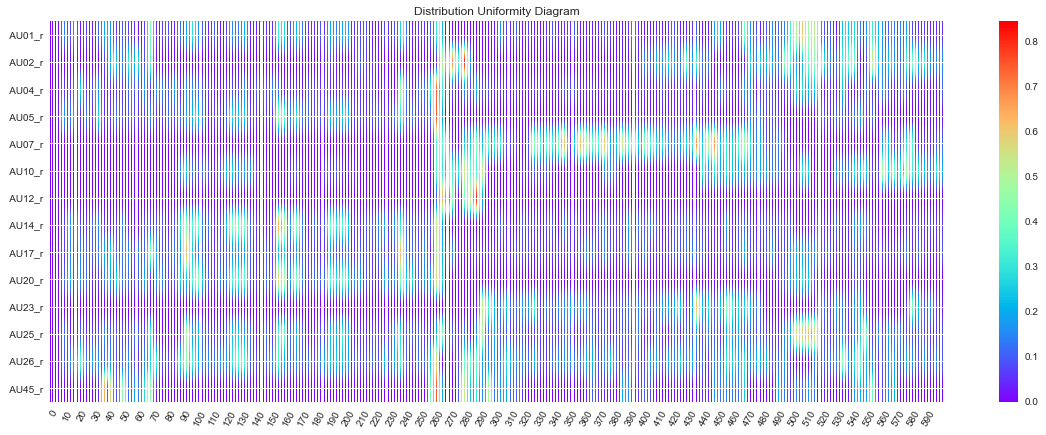

In [16]:
_ = complexity_resonance_diagram(distribution_uniformity_df,
                                plot_title='Distribution Uniformity Diagram')

In [17]:
fluctuation_intensity_df = pd.DataFrame(fluctuation_intensity(scaled_ts_df, 
                                                                  win=7, 
                                                                  xmin=0, 
                                                                  xmax=1, 
                                                                  col_first=1, 
                                                                  col_last=scaled_ts_df.shape[1])
                                         )
fluctuation_intensity_df.columns=scaled_ts_df.columns.tolist()

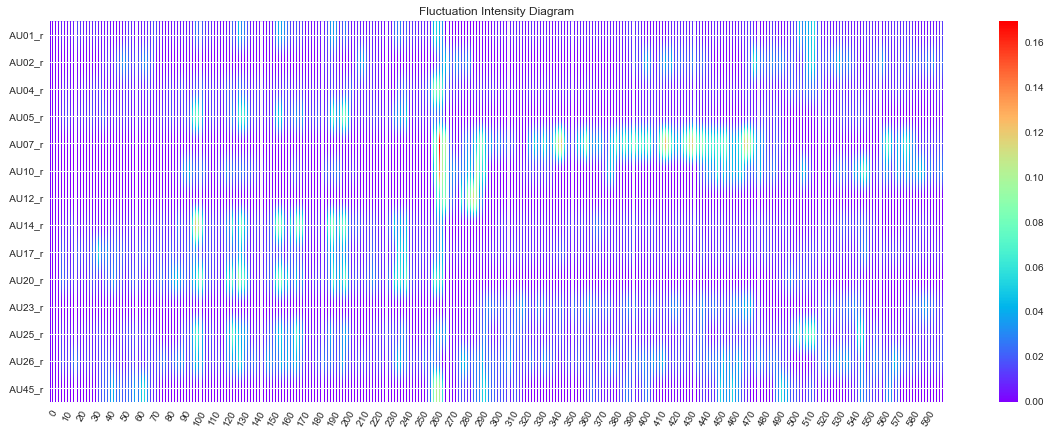

In [18]:
_ = complexity_resonance_diagram(fluctuation_intensity_df,
                                plot_title='Fluctuation Intensity Diagram')

In [19]:
complexity_resonance_df = complexity_resonance(distribution_uniformity_df, fluctuation_intensity_df)

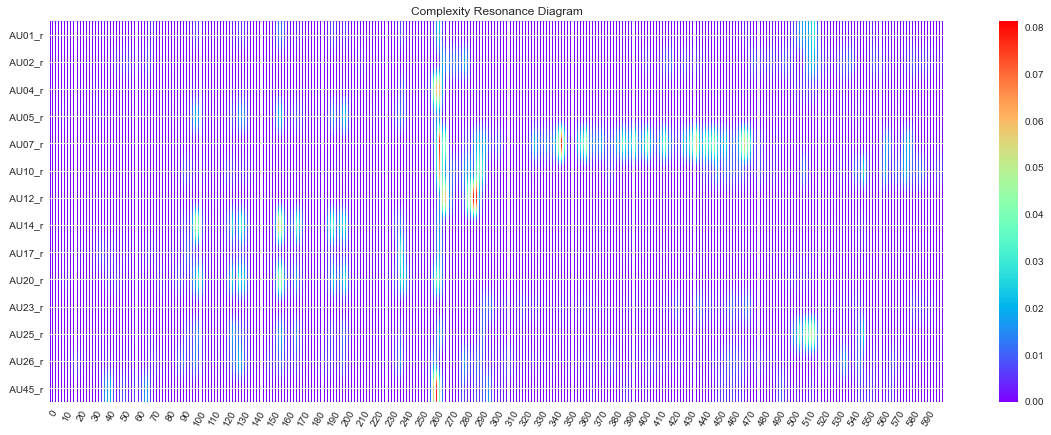

In [20]:
_ = complexity_resonance_diagram(complexity_resonance_df)

In [21]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

In [22]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)

(complexity_resonance_df
 .loc[0:100,:]
 .T
 .style.background_gradient(cmap, axis=1)
    .set_properties(**{'max-width': '180px', 'font-size': '5pt'})
    .set_caption("Complexity Resonance Df (Hover to magnify)")
    .set_precision(2)
    .set_table_styles(magnify())
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
AU01_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
AU02_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AU04_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AU05_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.02,0.02,0.02,0.01
AU07_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AU10_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AU12_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AU14_r,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

In [23]:
cumulative_complexity_peaks_df, significant_peaks_df = cumulative_complexity_peaks(df=complexity_resonance_df)

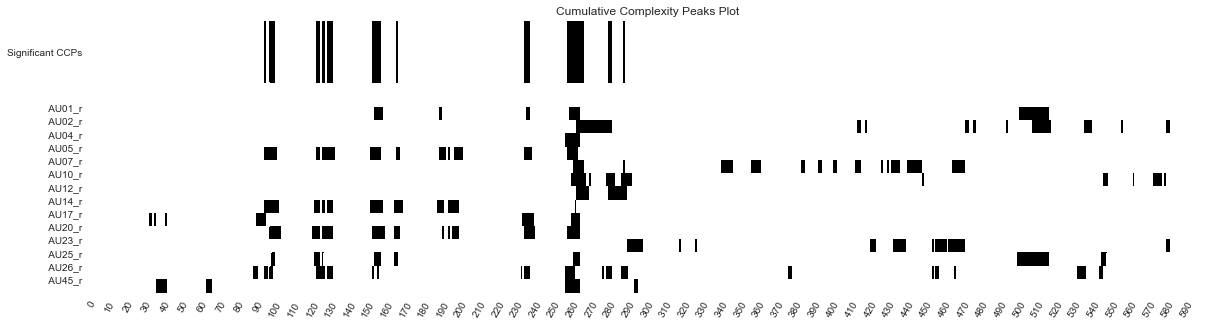

In [24]:
_ = cumulative_complexity_peaks_plot(cumulative_complexity_peaks_df=cumulative_complexity_peaks_df,
                                    significant_peaks_df=significant_peaks_df,
                                )

## Ts_levels example feature

In [25]:
example_feature = scaled_ts_df.columns[0]

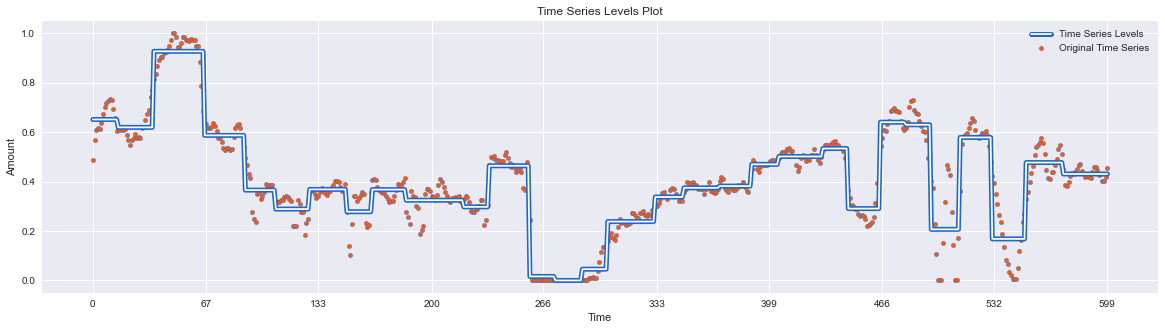

In [26]:
ts_levels_df, fig, ax = ts_levels(ts=scaled_ts_df[example_feature], 
                                  ts_x=None, 
                                  criterion="mse", 
                                  max_depth=10, 
                                  min_samples_leaf=15,
                                  min_samples_split=2, 
                                  max_leaf_nodes=30, 
                                  plot=True, 
                                  equal_spaced=True, 
                                  n_x_ticks=10)

### Plot all of the time series levels of the FACS

In [27]:
all_ts_levels = pd.DataFrame()

for column in scaled_ts_df.columns.tolist():
    ts_levels_df, fig, ax = ts_levels(ts=scaled_ts_df[column], 
                                  ts_x=None, 
                                  criterion="mse", 
                                  max_depth=10, 
                                  min_samples_leaf=15,
                                  min_samples_split=2, 
                                  max_leaf_nodes=30, 
                                  plot=False, 
                                  equal_spaced=True, 
                                  n_x_ticks=10)
    _ = ts_levels_df.set_index("t_steps", inplace=True)
    ts_levels_df.columns = [f"{column[1:]}_{x}" for x in ts_levels_df.columns.tolist()]
    all_ts_levels = pd.concat([all_ts_levels, ts_levels_df], axis=1)

In [28]:
plot_df = (all_ts_levels
           .reset_index()
           .melt(id_vars="t_steps"))

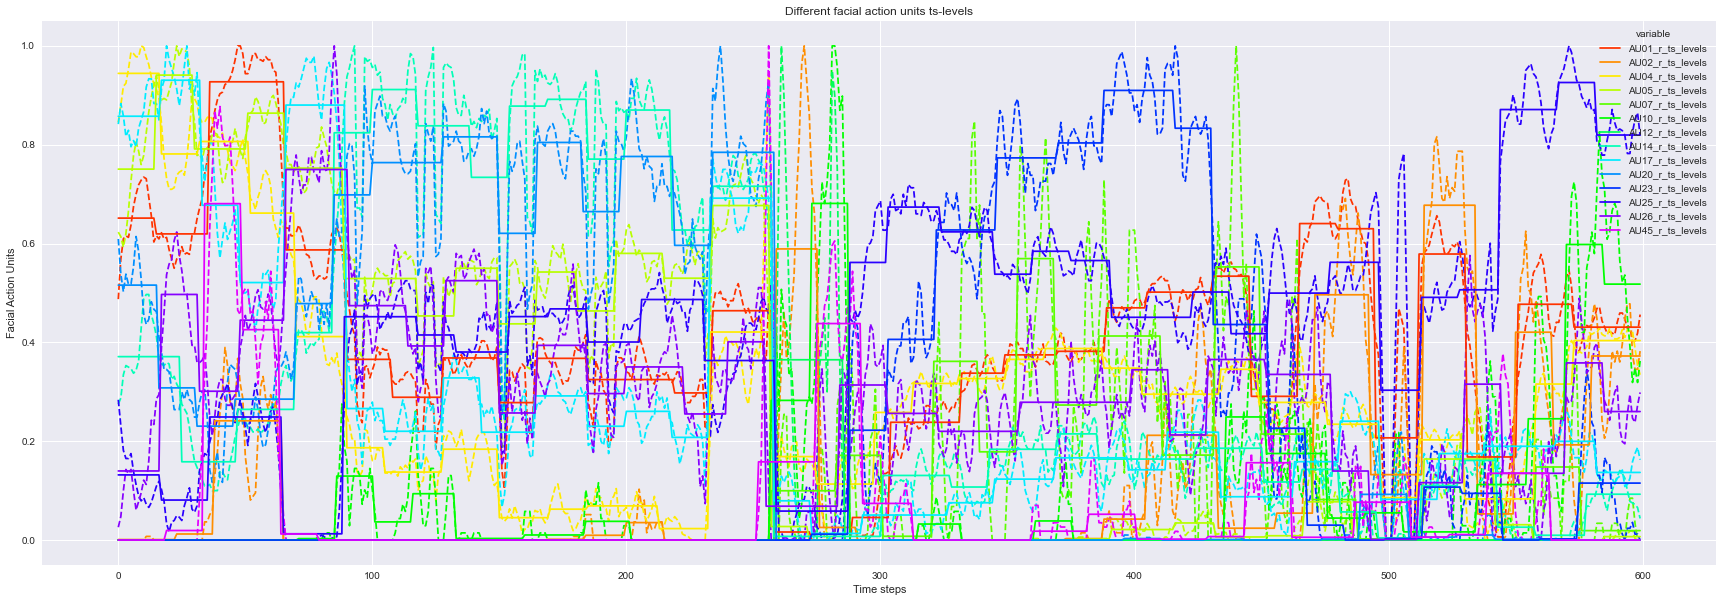

In [29]:
plt.figure(figsize=(30, 10))
ax = sns.lineplot(x="t_steps", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("original_ts")],
                  legend=False,
                  linestyle='dashed',
                 )
ax = sns.lineplot(x="t_steps", 
                  y="value",
                  hue="variable", 
                  palette="gist_rainbow",
                  data=plot_df[plot_df["variable"].str.contains("ts_levels")],
                 )
_ = ax.set(xlabel='Time steps', ylabel='Facial Action Units', 
           title='Different facial action units ts-levels')